# Identity Neural Network
One simple yet powerful test of a neural network is an identity model, or a network that outputs exactly what it receives as input. In this tutorial, we demonstrate how to build and deploy an identity neural network using Liquid Instruments’ Moku API. This example uses a rolling window of 100 input samples from a given channel and downsamples by a factor of 100, outputting one sample per 100-input frame. This approach verifies that the Moku Neural Network instrument preserves signal integrity, and it shows how to define and test a custom neural network model on the Moku hardware. We'll walk through the following steps:
1. Prepare the environment: install required packages and import libraries.
2. Build the identity model: define a network architecture that will learn to directly map input to output.
3. Test the model: use the model to process real data and visualize the output to confirm it matches the input.

## 1. Prepare the environment
First, ensure that the Moku API (with neural network support) and its dependencies are installed or updated by running the following commands. 

In [1]:
# Uncomment and run this if Moku library is not installed

#! python.exe -m pip install --upgrade pip
#! pip install --upgrade moku
#! pip install zeroconf
#! pip install --q 'moku[neuralnetwork]'

After installing the packages, import the relevant Python libraries. We import NumPy for numerical operations, Matplotlib for plotting, and the Moku neural network classes (LinnModel and save_linn) from the moku.nn module. We also set a random seed for reproducibility when generating data.

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    raise

## 2. Build and configure the identity model

For this example, we will configure an identity neural network that takes an input vector of length 100 and outputs an identical vector. We choose 100 because the Moku Neural Network supports up to 100 inputs in a single layer, a typical frame length for processing time-series data. 

In [3]:
'''Generate a sample input
Here we create a random input signal consisting of 100 random values. 
In a real scenario, this could be a segment of your time-series data. '''
frame_length = 100
data = np.random.rand(frame_length).astype(np.float32)

Here we initialize the model, using LinnModel from the Moku API to create a quantized neural network model container. This object will allow us to define layers, train or configure the network, and eventually export it for deployment.

In [4]:
quant_mod_identity = LinnModel()

In this case, the term "training data" should not be interpreted literally, since no training is taking place. Here it's simply used to meet the Neural Network API's requirement for specifying a training dataset and to define the input dimensions.

We specify scale=False to indicate that the data is already in the normalized range expected by the model. Moku assumes that inputs and outputs are in the range [-1, 1] by default. Our random data is 0 to 1, so we skip any scaling.

In [5]:
quant_mod_identity.set_training_data(training_inputs=data, 
                                     training_outputs=data, 
                                     scale=False)




Next we define the network architecture. Our identity model will consist of a single dense layer with 100 neurons and a linear activation function. A linear activation means no transformation, which is suitable for an identity pass-through. We want the layer's weight matrix to be the identity matrix and the bias vector to be zero, so that the output equals the input.

In [6]:
# Define a single-layer neural network: 100 neurons, linear activation
model_definition = [(frame_length, 'linear')]

# Build the model architecture as specified
quant_mod_identity.construct_model(model_definition)

At this point, the model has been constructed. Initially, the weights in the dense layer are randomly initialized and the biases start at zero. We will verify and then override these weights to turn the network into a true identity mapper. 

LinnModel uses Keras under the hood, so we can easily check the layer weights. The model's first layer (layers[0]) is an input layer, and the second layer (layers[1]) is our dense layer. Let's fetch the dense layer and look at its weight matrix and bias vector before configuring the identity Neural Network. 

In [7]:
dense_layer = quant_mod_identity.model.layers[1]  # The Dense layer

# Get the initial weights and biases (Keras initialization)
kernel_weights, bias_vector = dense_layer.get_weights()
print("Initial kernel weights:\n", kernel_weights)
print("\nInitial bias vector:\n", bias_vector)


Initial kernel weights:
 [[ 0.15837964 -0.13858186 -0.14870131 ...  0.07008755 -0.11106947
   0.07130057]
 [ 0.01180001  0.06581485 -0.0752875  ... -0.11469375 -0.0037718
   0.13671166]
 [-0.11700484  0.06718974 -0.14237483 ... -0.14353101  0.14819142
   0.03352691]
 ...
 [-0.02998286 -0.0507884   0.06834592 ... -0.03165174 -0.16248767
   0.14525956]
 [ 0.09322193 -0.08391244  0.14549035 ...  0.01756987 -0.16656235
  -0.08413151]
 [-0.06534698 -0.03069773 -0.05909544 ... -0.05260552 -0.15863283
   0.02855909]]

Initial bias vector:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
# Manually set weights to identity
identity_matrix = np.eye(frame_length, dtype=np.float32)
zero_bias = np.zeros(frame_length, dtype=np.float32)

print('Identity Matrix \n', identity_matrix, '\n')
print('Zero Bias \n', zero_bias)

Identity Matrix 
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 

Zero Bias 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


The biases are zero, but the weights are random small numbers, which we need to replace with an identity.

To do that, we will redefine the dense layer's weight matrix to the identity matrix and its bias vector to all zeros. The identity matrix has ones on the diagonal and zeros elsewhere, which will make each output neuron copy the corresponding input neuron’s value. The desired identity matrix should be of shape 100×100 in this case, which we create using np.eye. Let's apply these weights to the model and verify it worked correctly.

In [9]:
# Create an identity matrix and zero bias vector of length 100
identity_matrix = np.eye(frame_length, dtype=np.float32)
zero_bias = np.zeros(frame_length, dtype=np.float32)

# Overwrite the dense layer's weights with the identity matrix and zero biases
dense_layer.set_weights([identity_matrix, zero_bias])

# Retrieve the weights again to confirm they were set correctly
kernel_weights, bias_vector = dense_layer.get_weights()
print("Kernel weights after setting to identity:\n", kernel_weights)
print("\nBias vector after setting to zero:\n", bias_vector)


Kernel weights after setting to identity:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

Bias vector after setting to zero:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


Now our neural network is truly an identity function for a 100-sample input frame. We did not need to run a training loop in this case, instead we manually configured the weights to achieve the needed configuration from the start.

The last step in building the model is to export it to a file that can be loaded onto the Moku device. We use save_linn for this, specifying the number of input and output channels and the file name. Because our model processes one input channel and produces one output channel, we set input_channels=1 and output_channels=1. We also use the output_mapping parameter to select which element of the model's output vector should map to the physical output channel of the instrument. In this example we choose the last element (index 99) to output, meaning the model outputs the latest sample of each 100-sample frame.

In [10]:
model_filename = "AD_model_identity.linn" # Save the model to a .linn file for the Moku Neural Network instrument

# The output_mapping [frame_length-1] means: output the last sample of the 100-length output vector
save_linn(quant_mod_identity, input_channels=1, output_channels=1, 
          file_name=model_filename, output_mapping=[frame_length-1])


Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 103 cycles


# 3. Testing the model

With the identity neural network built and saved, we can perform a quick test to ensure it behaves as expected. We will use the model to predict an output from the input data and then compare or plot the result. Since this is an identity model, the output should match the input exactly - aside from any minor numerical precision differences. When deployed on the Moku hardware, the model will continuously process incoming data frames and output the selected sample. For our offline test, we use the LinnModel.predict() method on the same data we used to configure the model.

In [11]:
# Use the model to reconstruct the output from the input
reconstructed_output = quant_mod_identity.predict(data.reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Here, data.reshape(1, -1) shapes our data array into the expected input format. The predict function returns a NumPy array; in this case reconstructed_output will be of shape (1, 100).

Now, let's visualize the original signal versus the reconstructed signal to confirm they are identical.

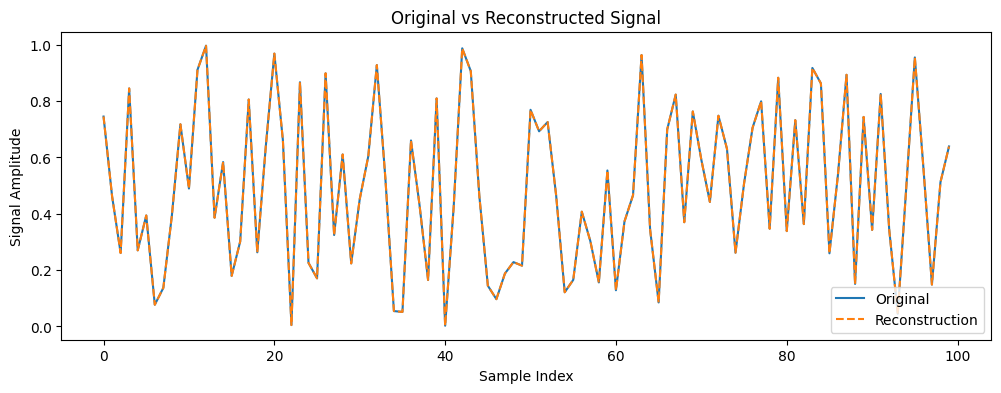

In [12]:
plt.figure(figsize=(12,4))
plt.plot(data, label='Original')
plt.plot(reconstructed_output[0], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.show()


As seen, the original input signal (solid orange line) and the reconstructed output signal (dashed blue line) completely overlap. The output from the neural network is identical to the input, confirming that the model behaves as expected. 

In this example, we successfully constructed and verified an identity neural network using the Moku API. This simple model serves as a baseline test for the Moku Neural Network instrument’s precision and can act as a starting point for more complex models. You can now deploy the saved .linn model to your Moku device, where it should output a signal identical to the input. From this point, you can move on to training more sophisticated models on your data.